In [20]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as imag
from torch.utils.data import Dataset, DataLoader
from matplotlib.dates import datestr2num
import torch.optim as optim
from sklearn import preprocessing
import math
from scipy.stats import gaussian_kde
# plt.ion()

In [3]:
FILENAME = 'augmented_data.csv'

BATCH_SIZE = 128
TRAIN_SPLIT = 0.8

NUM_FEATURES = 24
NUM_UNITS = 32
NUM_USERS = 9
NUM_EPOCHS = 1

EPSILON = 0.05
DELTA = 10**-5
NORM_CLIP=4.0

SIGMA = 0.3

MAP_PARAMS = 2

NUM_GRIDS = 4

## Load Data

In [4]:
userID = {
'a841f74e620f74ec443b7a25d7569545':0,
'22223276ea84bbce3a62073c164391fd':1,
'510635002cb29804d54bff664cab52be':2,
'7cbc37da05801d46e7d80c3b99fd5adb':3,
'7023889b4439d2c02977ba152d6f4c6e':4,
'8425a81da55ec16b7f9f80c139c235a2':5,
'6882f6cf8c72d6324ba7e6bb42c9c7c2':6,
'1e33db5d2be36268b944359fbdbdad21':7,
'892d2c3aae6e51f23bf8666c2314b52f':8,
}

In [5]:
class ChaniaDataset(Dataset):
    def __init__(self, csv_file, transform=None, normalize=True):
        self.augmented_data = pd.read_csv(csv_file, header=0, usecols = [0]+list(range(2,21))+list(range(22,26)), 
                                          converters={0:lambda x: datestr2num(x)})
        self.userlabels = pd.read_csv(csv_file, header=0, usecols=["iPhoneUID"],converters={"iPhoneUID": lambda x: userID[x]})
        self.transform = transform
        
        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean())/self.augmented_data.std()

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data.iloc[idx].values
        data = data.astype('float').reshape(-1,NUM_FEATURES)            
        user = self.userlabels.iloc[idx].values
        user = user.astype('int').reshape(-1,1)
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}

In [12]:
chania_dataset = ChaniaDataset(csv_file=FILENAME, transform=ToTensor(), normalize=False)

In [47]:
np.array([chania_dataset[x]['u'].item() for x in range(100)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

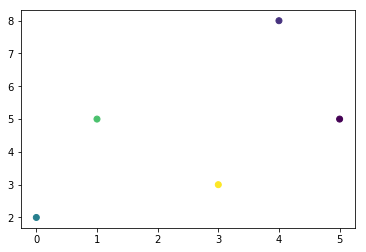

In [51]:
plt.scatter([0,1,3,4,5],[2,5,3,8,5],c=[4,6,8,2,1])

In [57]:
from matplotlib.pyplot import savefig

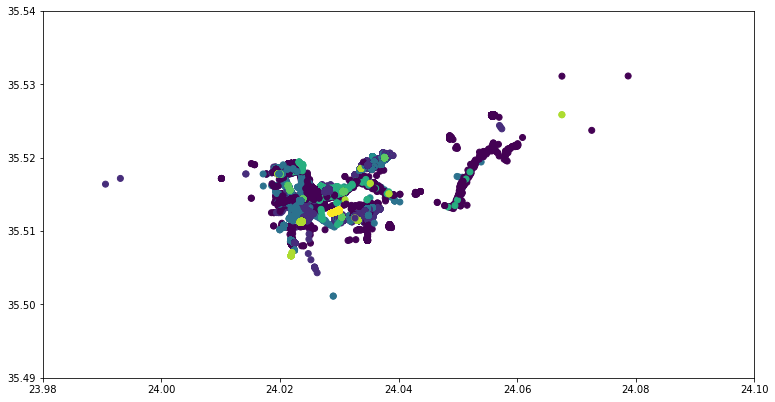

In [58]:
plt.figure(figsize=(8.5*1.5,4.5*1.5))
plt.scatter(chania_dataset.augmented_data['longitude'].values, 
            chania_dataset.augmented_data['latitude'].values,
           c = [chania_dataset[x]['u'].item() for x in range(len(chania_dataset.augmented_data['longitude'].values))])
plt.xlim(23.98, 24.10)
plt.ylim(35.49,35.54)
savefig('chaniaPOINTS.png',transparent=True)

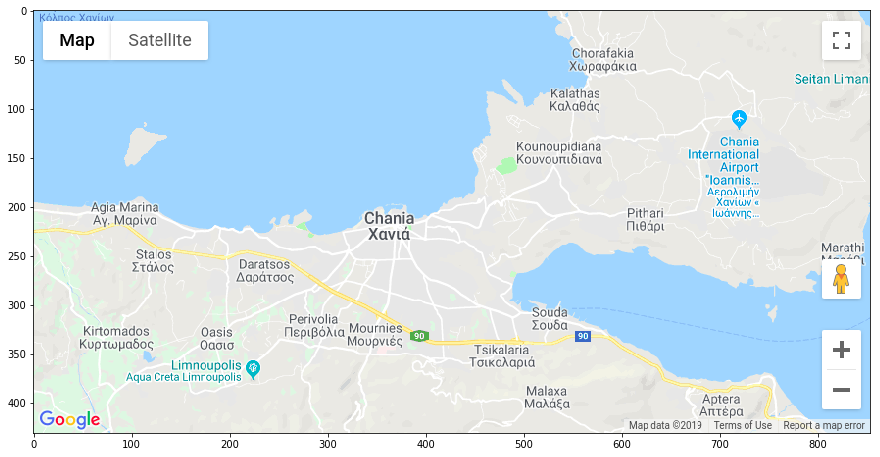

In [30]:
plt.figure(figsize=(15,15))
img = imag.imread('chaniabounded.png')
plt.imshow(img)

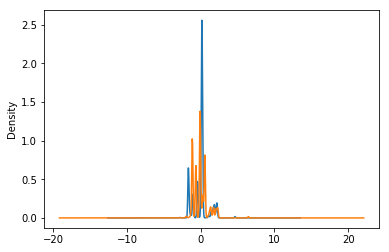

In [117]:
chania_dataset.augmented_data['latitude'].plot(kind='density')
chania_dataset.augmented_data['longitude'].plot(kind='density')

In [8]:
train_size=int(TRAIN_SPLIT*len(chania_dataset))
test_size = len(chania_dataset)-train_size

In [9]:
train_dataset, test_dataset = torch.utils.data.random_split(chania_dataset, [train_size, test_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Visualize Functions

In [11]:
def show_batch_wlabels(sample_batch,longlines=None,latlines=None):
    data, users = sample_batch['x'], sample_batch['u']
    batch_size = len(data)
    colors = users.numpy()[:,0].tolist()
    for i in range(batch_size):
        plt.scatter(data[:,:,13].numpy(), data[:,:,12].numpy(), c=colors)
    if longlines is not None:
        for line in longlines.numpy():
            plt.axvline(line)
    if latlines is not None:
        for line in latlines.numpy():
            plt.axhline(line)

In [101]:
def show_privatizer(x, y, u, uhat):
    with torch.no_grad():
        fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
        ax[0,0].set_title("X")
        ax[0,1].set_title("Y")
        ax[1,0].set_title("U")
        ax[1,1].set_title("Uhat")
        ax[0,0].scatter(x[:,:,13].numpy(),x[:,:,12].numpy(),c=x[:,:,6].numpy())
        ax[0,1].scatter(y[:,:,13].numpy(),y[:,:,12].numpy(),c=y[:,:,6].numpy())
        ax[1,0].scatter(y[:,:,13].numpy(),y[:,:,12].numpy(),c=u.unsqueeze(0).numpy().T.tolist())
        _, upred = torch.max(uhat.data,1)
        ax[1,1].scatter(y[:,:,13].numpy(),y[:,:,12].numpy(),c=upred.unsqueeze(0).numpy().T.tolist())

## Define helper functions

In [13]:
def privatizer_loss(x,y,u,uhat):
    bx = signal_map_params(x,MAP_PARAMS)
    by = signal_map_params(y,MAP_PARAMS)
    l1 = (bx-by).pow(2).mean()
    l2 = (x-y).pow(2).mean()
    l3 = (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean()
    cx,_,_ = density_count(x,NUM_GRIDS)
    cy,_,_ = density_count(y,NUM_GRIDS)
    l4 = (cx-cy).pow(2).mean()/BATCH_SIZE
    l = torch.nn.CrossEntropyLoss()
    l5 = l(uhat,u)
    return l1+l2+l3+l4-l5

In [14]:
def signal_map_params(x,degree):
    def poly(degree, long, lat):
        return torch.cat([long**i*lat**(degree-i) for degree in range(MAP_PARAMS+1) for i in range(degree,-1,-1)],1)
    
    polynomial = poly(MAP_PARAMS, x[:,:,13], x[:,:,12])
    beta = torch.mm(torch.inverse(torch.mm(torch.transpose(polynomial,0,1), polynomial)),
                  torch.mm(torch.transpose(polynomial,0,1), x[:,:,6]))
    return beta

In [15]:
def density_count(x, num_grids):
    count = torch.zeros(num_grids,num_grids)
    x1min=torch.min(x[:,:,13])
    x2min=torch.min(x[:,:,12])
    size1 = torch.max(x[:,:,13])-x1min
    size2 = torch.max(x[:,:,12])-x2min
    a_all = []
    c_all = []
    for i in range(num_grids):
        for j in range(num_grids):
            a = x1min+(size1/num_grids*i)
            a_all.append(a)
            b = x1min+(size1/num_grids*(i+1))
            a_all.append(b)
            c = x2min+(size2/num_grids*j)
            c_all.append(c)
            d = x2min+(size2/num_grids*(j+1))
            c_all.append(d)
            if i == num_grids-1 and j != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
            elif j == num_grids-1 and i != num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            elif j == num_grids-1 and i == num_grids-1:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] <= b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] <= d)].size(0)
            else:
                count[i][j] += x[(x[:,:,13] >= a ) & 
                                 (x[:,:,13] < b) & 
                                 (x[:,:,12] >= c) & 
                                 (x[:,:,12] < d)].size(0)
    return count, torch.unique(torch.Tensor(a_all)), torch.unique(torch.Tensor(c_all))

## Define adversary

In [16]:
adversary = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_USERS)
)
adversary.double()

Sequential(
  (0): Linear(in_features=24, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=9, bias=True)
)

In [17]:
POPULARITY = torch.DoubleTensor([1,2,0.001,1,0.001,0.001,1,0.75,0.5])
adversary_loss = torch.nn.CrossEntropyLoss() #add POPULARITY if desired
adversary_optimizer = optim.Adam(adversary.parameters(),lr=0.001, betas=(0.9,0.999))

## Define privatizers

#### GAP

In [18]:
gap_privatizer = torch.nn.Sequential(
    torch.nn.Linear(NUM_FEATURES, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_UNITS),
    torch.nn.ReLU(),
    torch.nn.Linear(NUM_UNITS, NUM_FEATURES)
)
gap_privatizer.double()
gap_privatizer_optimizer = optim.Adam(gap_privatizer.parameters(),lr=0.001, betas=(0.9,0.999))

#### Local DP

In [19]:
def dp_privatizer(x):
    normvec = torch.norm(x,p=2,dim=2)
    scalevec = NORM_CLIP/normvec
    scalevec[scalevec>1] = 1
    x = torch.transpose(torch.transpose(x,0,1)*scalevec,0,1).double()
    sigma = (NORM_CLIP/EPSILON)*math.sqrt(2*math.log(1.25/DELTA))
    noise = torch.normal(mean=torch.zeros_like(x),std=sigma).double()
    y = x + noise
    return y

#### Gaussian Noise

In [20]:
def noise_privatizer(x):
    noise = torch.normal(mean=torch.zeros_like(x),std=SIGMA).double()
    y = x + noise
    return y

# TRAIN

In [21]:
PRIVATIZER = noise_privatizer

In [22]:
# for each epoch
for epoch in range(NUM_EPOCHS):
    
    # iterate through the training dataset
    for i, batch in enumerate(train_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        if PRIVATIZER == gap_privatizer:
            # reset privatizer gradients
            gap_privatizer_optimizer.zero_grad()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # reset adversary gradients
        adversary_optimizer.zero_grad()
        
        # estimate userIDs
        uhat = adversary(x).squeeze()
        
        # train adversary
        aloss = adversary_loss(uhat, u)
        aloss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(adversary.parameters(), 1000)
        adversary_optimizer.step()
        
        # evaluate utility loss
        ploss = privatizer_loss(x,y,u,uhat)
        
        if PRIVATIZER == gap_privatizer:
            # train privatizer
            ploss.backward()
            torch.nn.utils.clip_grad_norm_(gap_privatizer.parameters(), 1000)
            gap_privatizer_optimizer.step()
        
        # print progress
        if i % 10 == 9:
            print(i+1,"aloss:",aloss.item(),"ploss:",ploss.item())
          
        # stop early
        if i == 20:
            break
print("done")

10 aloss: 2.1480946523746014 ploss: -1.6614035739194015
20 aloss: 2.128839521172524 ploss: -1.0470806086902256
done


# Test

In [25]:
# do not keep track of gradients
with torch.no_grad():
    correct = 0
    total = 0
    l1,l2,l3,l4,l5 = 0,0,0,0,0
    
    # iterate through test data
    for i,batch in enumerate(test_loader):
        
        # unpack batch
        x, u = batch['x'], batch['u'].squeeze()
        
        # privatize x
        y = PRIVATIZER(x)
        
        # estimate userID
        uhat = adversary(y).squeeze()
        
        # Privacy Metric
        _, upred = torch.max(uhat.data,1)
        total+=u.size(0)
        correct+=(upred==u).sum().item()
        
        # Utility Metrics
        l = torch.nn.CrossEntropyLoss()
        l5 += l(uhat,u).item()
        bx = signal_map_params(x,MAP_PARAMS)
        by = signal_map_params(y,MAP_PARAMS)
        l1 += (bx-by).pow(2).mean().item()
        l2 += (y-x).pow(2).mean().item()
        l3 += (y[:,:,12:14]-x[:,:,12:14]).pow(2).mean().item()
        cx,_,_ = density_count(x,NUM_GRIDS)
        cy,_,_ = density_count(y,NUM_GRIDS)
        l4 += (cx-cy).pow(2).mean().item()/BATCH_SIZE
        
        # stop early
        if i==0:
            break
        
    print("Adversary Accuracy:", 100*correct/total)
    print("")
    
    print("Adversary Loss:", l5/(i+1))
    print("Sigmal Map:", l1/(i+1))
    print("Distortion:", l2/(i+1))
    print("Geographic Distortion:", l3/(i+1))
    print("Density Count:",l4/(i+1))

Adversary Accuracy: 26.5625

Adversary Loss: 2.103212505276637
Sigmal Map: 0.19632284630319394
Distortion: 0.09041344261993896
Geographic Distortion: 0.08956472412524322
Density Count: 0.1923828125


# Visualize

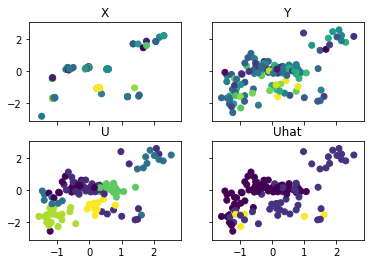

In [102]:
show_privatizer(x,y,u,uhat)

# Probability Distributions

In [137]:
x[:,:,12].numpy().T[0]

array([ 0.19743254,  1.71132391,  0.1355278 ,  0.23340694,  0.12525002,
        0.11933165,  0.10308259,  0.21444873,  0.19057524, -0.41862017,
        1.8632489 ,  0.22010997, -0.44004874,  0.12337797, -1.07130547,
       -1.58640105,  1.71132391, -1.07130547,  0.19057524,  0.09205182,
        0.23647701,  0.12939505,  0.14206148, -1.67046053, -1.55861387,
       -1.41305515, -1.03859357,  0.2180218 , -1.03859357,  0.22469742,
       -0.41105992,  0.1355278 ,  0.19786305, -1.58640105,  0.12337797,
       -1.48077933, -1.66052194, -1.68651534,  2.22201225,  0.23340694,
       -1.037289  ,  0.1258472 ,  0.12525002, -0.44847756, -1.67590564,
        2.13168   ,  0.2419116 ,  0.18066348,  0.23732236,  0.21568228,
       -1.68651534,  0.11395394,  0.14206148,  0.29257232,  0.12337797,
       -1.65734894,  0.23473846, -1.07130547,  0.23566631,  0.20250746,
        0.1773325 , -1.67929459, -1.03444649,  0.1355278 , -0.41550631,
       -1.07130547, -1.67929459, -1.03444649, -1.68651534,  1.70

In [202]:
# generated a density class
lat_distr = gaussian_kde(x[:,:,12].numpy().T[0])
long_distr = gaussian_kde(x[:,:,13].numpy().T[0])

# set the covariance_factor, lower means more detail
lat_distr.covariance_factor = lambda : BATCH_SIZE**(-1./(1+4))
lat_distr._compute_covariance()
long_distr.covariance_factor = lambda : BATCH_SIZE**(-1./(1+4))
long_distr._compute_covariance()

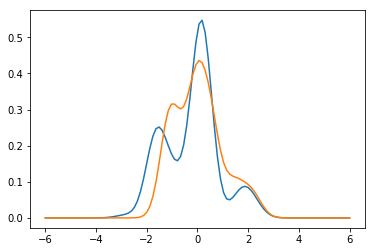

In [203]:
testpoints = np.linspace(-6,6,100)
plt.plot(testpoints,lat_distr(testpoints))
plt.plot(testpoints,long_distr(testpoints))

In [204]:
newsamplelat = lat_distr.resample(128)
newsamplelong = long_distr.resample(128)

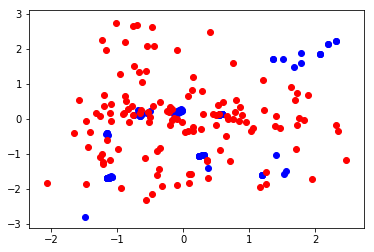

In [205]:
plt.scatter(x[:,:,13],x[:,:,12],c="b")
plt.scatter(newsamplelong,newsamplelat,c="r")

In [225]:
# generated a density class
coord_distr = gaussian_kde(x[:,:,12:14].squeeze().numpy().T)

# set the covariance_factor, lower means more detail
coord_distr.covariance_factor = lambda : BATCH_SIZE**(-2./(1+4))
coord_distr._compute_covariance()

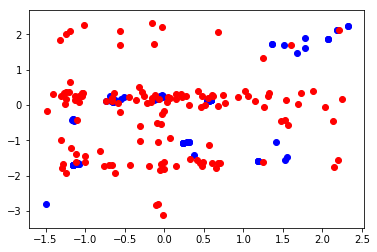

In [235]:
plt.scatter(x[:,:,13],x[:,:,12],c="b")
plt.scatter(coord_distr.resample(128)[1],coord_distr.resample(128)[0],c="r")

In [259]:
def theoretical_privatizer(x):
    prob_distr = gaussian_kde(x.numpy().squeeze().T)
    prob_distr.covariance_factor = lambda : BATCH_SIZE**(-NUM_FEATURES/(1+4))
    prob_distr._compute_covariance()
    y = prob_distr.resample(128).T
    return torch.Tensor(y.reshape(BATCH_SIZE,1,NUM_FEATURES))

In [260]:
print(theoretical_privatizer(x).size())

torch.Size([128, 1, 24])


array([[-1.2743052 ,  0.28804947,  0.6713439 , ...,  0.66144205,
         0.62444991,  0.08412223],
       [-0.12891717,  0.25354789, -0.12891717, ..., -0.12891717,
        -0.12891717,  0.63601296],
       [-0.28842876,  0.19043472, -0.28842876, ..., -0.28842876,
        -0.28842876,  0.19043472],
       ...,
       [-0.55938199, -0.55938199,  1.85154214, ..., -0.55938199,
        -0.55938199, -0.55938199],
       [-0.29456841, -0.29456841,  0.99501313, ..., -0.29456841,
        -0.29456841, -0.29456841],
       [-0.30595195, -0.30595195,  1.03228919, ..., -0.30595195,
        -0.30595195, -0.30595195]])